<a href="https://colab.research.google.com/github/svbinas/airquality/blob/main/Astana_Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium

In [2]:
file_path = '/content/airq1.xlsx'

airq = pd.read_excel(file_path)

airq['date'] = pd.to_datetime(airq['date'], errors='coerce')
print(airq)

summary_stats_by_code_sample = airq.groupby('code')['value'].describe().round(2)

missing_values_by_code_sample = airq.groupby('code').apply(lambda x: x.isnull().sum())

data_types_sample = airq.dtypes

print("Summary Statistics by Code:")
print(summary_stats_by_code_sample)

print("\nMissing Values by Code:")
print(missing_values_by_code_sample)

             date stationId   code       value
0      2021-12-01        k8  PM2.5    6.572000
1      2021-12-01        k4  PM2.5  211.532228
2      2021-12-01        k9  PM2.5    0.692667
3      2021-12-01        k7  PM2.5  125.142000
4      2021-12-01       k12  PM2.5  409.088446
...           ...       ...    ...         ...
466160 2024-04-30        k7     CO  286.932944
466161 2024-04-30        k7    NO2   25.531056
466162 2024-04-30        k7    SO2   29.361833
466163 2024-04-30        k7   PM10    9.268500
466164 2024-04-30        k9  PM2.5    1.755556

[466165 rows x 4 columns]
Summary Statistics by Code:
         count    mean     std  min     25%     50%     75%       max
code                                                                 
CO     99109.0  534.10  617.44  0.0  262.82  381.27  577.19  14332.85
NO2    92559.0   70.18  147.31  0.0    6.12   15.97   47.84    989.32
PM10   87579.0   54.03   89.23  0.0    9.81   21.47   59.12   1325.76
PM2.5  87794.0   42.69   87.20 

In [3]:
file_path = '/content/monthly_stats.xlsx'

df = pd.read_excel('monthly_stats.xlsx')
print(df)

    stationId code year_month       value
0         k12   CO    2021-12  149.404391
1         k12   CO    2022-01  244.082864
2         k12   CO    2022-02   83.721870
3         k12   CO    2022-03  114.375911
4         k12   CO    2022-04  224.807075
..        ...  ...        ...         ...
710        k9  SO2    2023-12   23.495005
711        k9  SO2    2024-01   27.599168
712        k9  SO2    2024-02   29.967501
713        k9  SO2    2024-03   27.265436
714        k9  SO2    2024-04   25.911915

[715 rows x 4 columns]


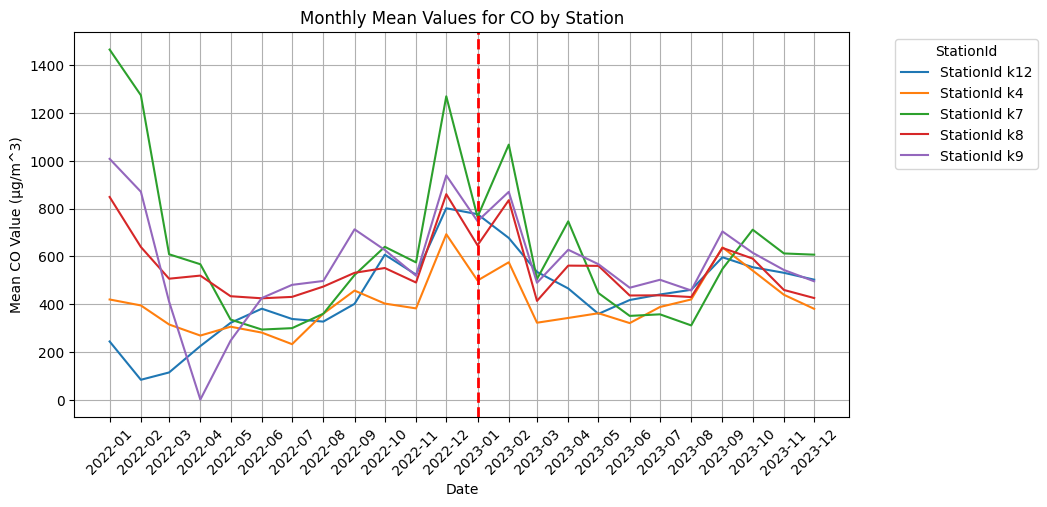

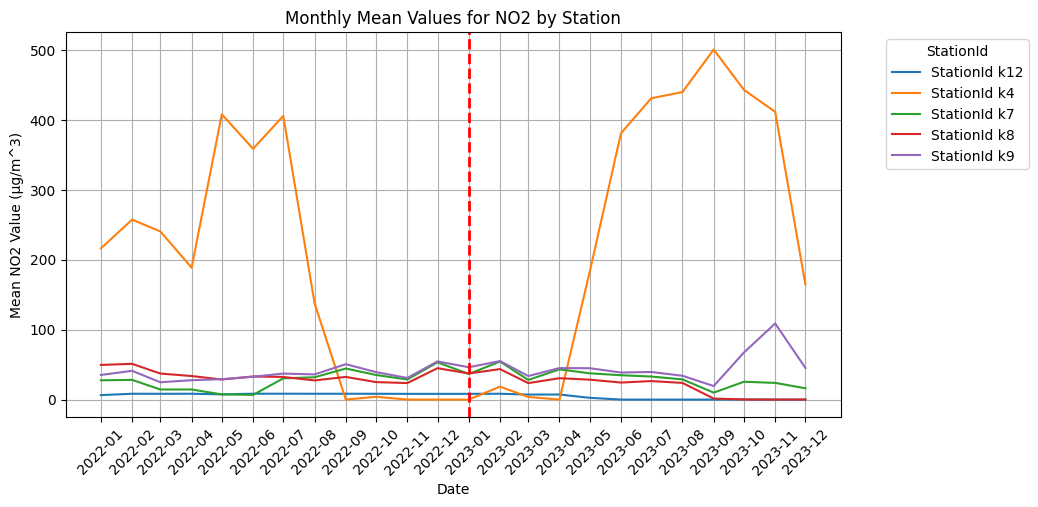

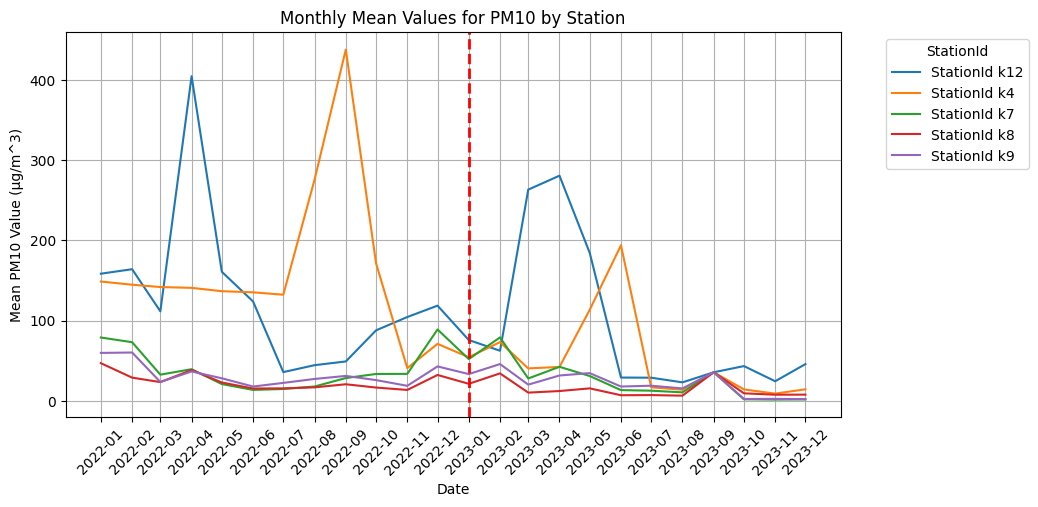

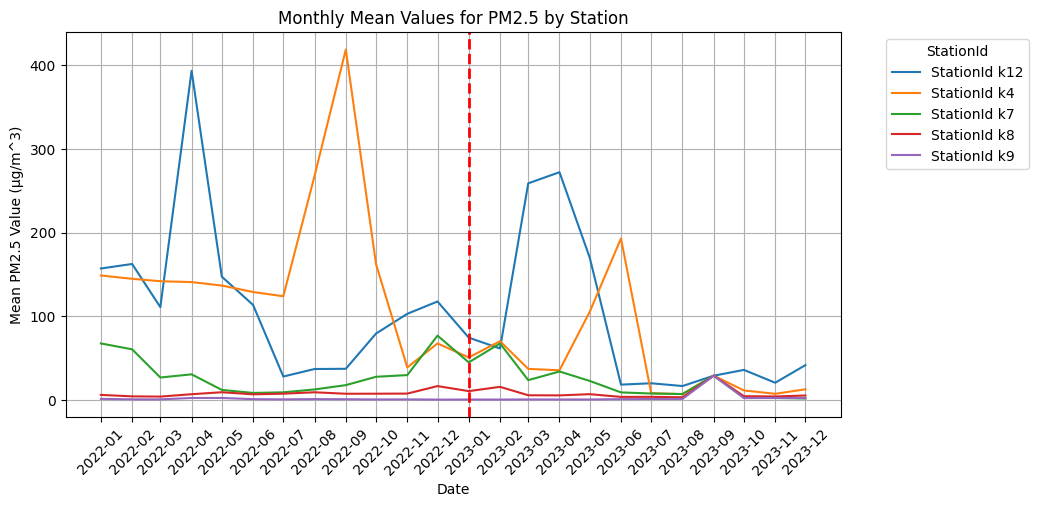

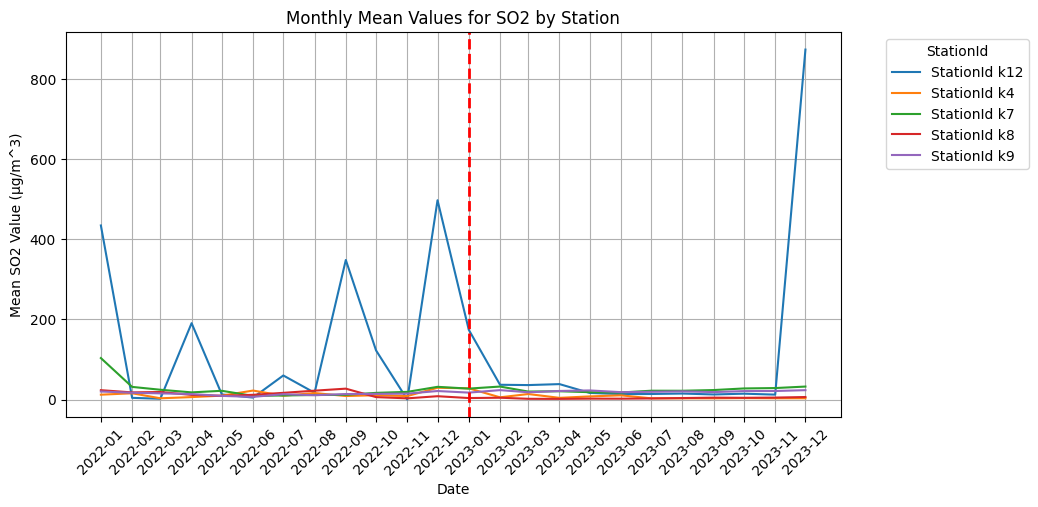

In [4]:
import matplotlib.pyplot as plt

df['year_month'] = pd.to_datetime(df['year_month'], errors='coerce')
df = df.dropna(subset=['year_month'])

df['year_month'] = df['year_month'].dt.to_period('M')

df = df[(df['year_month'] >= '2022-01') & (df['year_month'] <= '2023-12')]

monthly_mean = df.groupby(['stationId', 'code', 'year_month'])['value'].mean().reset_index()

unique_codes = monthly_mean['code'].unique()

for code in unique_codes:
    code_data = monthly_mean[monthly_mean['code'] == code]

    pivoted_data = code_data.pivot_table(index='year_month', columns='stationId', values='value')

    pivoted_data = pivoted_data.interpolate(method='linear')

    plt.figure(figsize=(10, 5))
    for col in pivoted_data.columns:
        plt.plot(pivoted_data.index.to_timestamp(), pivoted_data[col], label=f'StationId {col}')

    plt.xticks(pivoted_data.index.to_timestamp(), pivoted_data.index.strftime('%Y-%m'), rotation=45)

    plt.axvline(x=pd.Timestamp('2023-01-01'), color='red', linestyle='--', linewidth=2)

    plt.xlabel('Date')
    plt.ylabel(f'Mean {code} Value (μg/m^3)')
    plt.title(f'Monthly Mean Values for {code} by Station')
    plt.legend(title='StationId', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

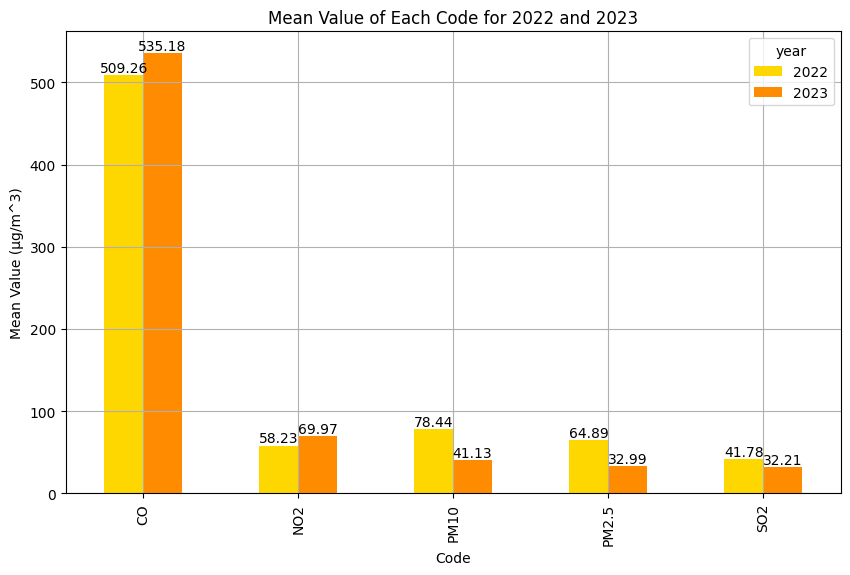

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/monthly_stats.xlsx'
df = pd.read_excel('monthly_stats.xlsx')

df['year_month'] = pd.to_datetime(df['year_month'])

df['year'] = df['year_month'].dt.year

df_filtered = df[df['year'].isin([2022, 2023])]

mean_values = df_filtered.groupby(['code', 'year'])['value'].mean().unstack()

ax = mean_values.plot(kind='bar', figsize=(10, 6), color=['#FFD700', '#FF8C00'])

plt.title('Mean Value of Each Code for 2022 and 2023')
plt.xlabel('Code')
plt.ylabel('Mean Value (μg/m^3)')
plt.grid()

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the data
file_path = '/content/monthly_stats.xlsx'
df = pd.read_excel(file_path)

# Prepare the data
df['year_month'] = pd.to_datetime(df['year_month'], errors='coerce')
df = df.dropna(subset=['year_month'])

df['year_month'] = df['year_month'].dt.to_period('M')

df = df[(df['year_month'] >= '2022-01') & (df['year_month'] <= '2023-12')]

aqi_breakpoints = {
    'CO': {
        'Good': [0, 1000],
        'Satisfactory': [1001, 2000],
        'Moderate': [2001, 10000],
        'Poor': [10001, 17000],
        'Very Poor': [17001, 34000],
        'Severe': [34001, float('inf')]
    },
    'PM10': {
        'Good': [0, 50],
        'Satisfactory': [51, 100],
        'Moderate': [101, 250],
        'Poor': [251, 350],
        'Very Poor': [351, 430],
        'Severe': [431, float('inf')]
    },
    'PM2.5': {
        'Good': [0, 30.00],
        'Satisfactory': [30.01, 60.00],
        'Moderate': [60.01, 90.00],
        'Poor': [90.01, 120.00],
        'Very Poor': [120.01, 250.00],
        'Severe': [250.01, float('inf')]
    },
    'NO2': {
        'Good': [0, 40],
        'Satisfactory': [41, 80],
        'Moderate': [81, 180],
        'Poor': [181, 280],
        'Very Poor': [281, 400],
        'Severe': [401, float('inf')]
    },
    'SO2': {
        'Good': [0, 40],
        'Satisfactory': [41, 80],
        'Moderate': [81, 380],
        'Poor': [381, 800],
        'Very Poor': [801, 1600],
        'Severe': [1601, float('inf')]
    }
}

def categorize_aqi(value, pollutant):
    for category, (low, high) in aqi_breakpoints.get(pollutant, {}).items():
        if low <= value <= high:
            return category
    return None

mean_values = df.groupby(['stationId', 'year_month', 'code'])['value'].mean().reset_index()

mean_values['AQI_Category'] = mean_values.apply(
    lambda row: categorize_aqi(row['value'], row['code']), axis=1
)

cmap = {
    'Good': '#00B050',
    'Satisfactory': '#92D050',
    'Moderate': '#FFFF00',
    'Poor': '#FF6500',
    'Very Poor': '#FF0000',
    'Severe': '#C00000'
}

output_dir = '/content/code_heatmaps'
os.makedirs(output_dir, exist_ok=True)

station_ids = mean_values['stationId'].unique()

for code in mean_values['code'].unique():
    code_data = mean_values[mean_values['code'] == code]

    heatmap_data = code_data.pivot(index='year_month', columns='stationId', values='value').reindex(columns=station_ids).sort_index(ascending=False)
    heatmap_categories = code_data.pivot(index='year_month', columns='stationId', values='AQI_Category').reindex(columns=station_ids).sort_index(ascending=False)
    heatmap_colors = heatmap_categories.apply(lambda x: x.map(cmap))

    fig, ax = plt.subplots(figsize=(14, 8))

    for (row, col), value in np.ndenumerate(heatmap_data.values):
        category = heatmap_categories.iloc[row, col]
        color = cmap.get(category, 'white')
        text_color = 'black' if color in ['#92D050', '#FFFF00'] else 'white'
        ax.add_patch(plt.Rectangle((col, row), 1, 1, facecolor=color, edgecolor='black', linewidth=0.5))
        ax.text(col + 0.5, row + 0.5, f'{value:.1f}', ha='center', va='center', color=text_color, fontsize=10)

    ax.set_xticks(np.arange(len(heatmap_data.columns)) + 0.5)
    ax.set_yticks(np.arange(len(heatmap_data.index)) + 0.5)

    ax.set_xticklabels(heatmap_data.columns, rotation=90)
    ax.set_yticklabels(heatmap_data.index)

    ax.set_xlim(0, len(heatmap_data.columns))
    ax.set_ylim(0, len(heatmap_data.index))

    ax.set_xlabel('StationID', fontsize=12)
    ax.set_ylabel('Date', fontsize=12)

    ax.grid(False)
    ax.set_title(f'Heatmap for {code}', fontsize=16)

    handles = [plt.Rectangle((0, 0), 1, 1, color=cmap[label]) for label in cmap.keys()]
    labels = list(cmap.keys())
    plt.legend(handles, labels, title="AQI Category", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.savefig(f'{output_dir}/heatmap_{code}.png', bbox_inches='tight')
    plt.close()


<ipython-input-7-ef0fd7cf95fd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_data['year_month'] = range_data['date'].dt.to_period('M')
<ipython-input-7-ef0fd7cf95fd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_data['year_month'] = range_data['date'].dt.to_period('M')
<ipython-input-7-ef0fd7cf95fd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

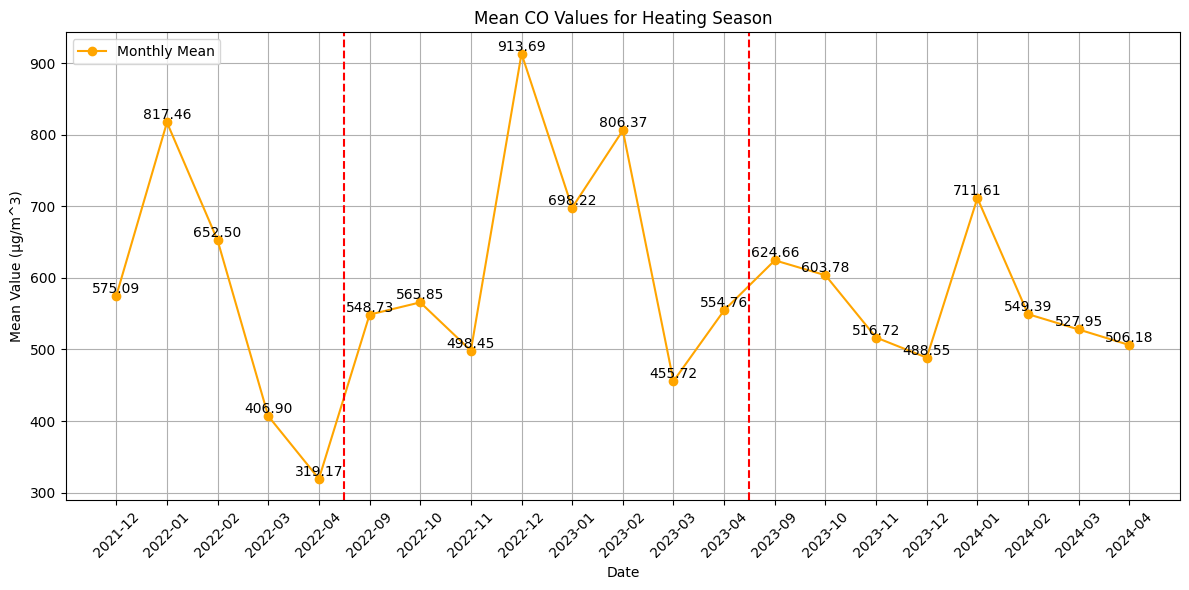

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fd = pd.read_excel('co_value.xlsx')

fd['date'] = pd.to_datetime(fd['date'])
fd['year_month'] = fd['date'].dt.to_period('M')
co_data = fd[fd['code'] == 'CO']

def calculate_mean_values_by_range(co_data, start_date, end_date):
    range_data = co_data[(co_data['date'] >= start_date) & (co_data['date'] <= end_date)]
    range_data['year_month'] = range_data['date'].dt.to_period('M')
    mean_values = range_data.groupby(['year_month'])['value'].mean().reset_index()
    return mean_values

mean_values_1 = calculate_mean_values_by_range(co_data, '2021-12-01', '2022-04-30')
mean_values_2 = calculate_mean_values_by_range(co_data, '2022-09-01', '2023-04-30')
mean_values_3 = calculate_mean_values_by_range(co_data, '2023-09-01', '2024-04-30')

combined_mean_values = pd.concat([mean_values_1, mean_values_2, mean_values_3])

combined_mean_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(combined_mean_values['year_month'].astype(str), combined_mean_values['value'], color='orange', marker='o', linestyle='-', label='Monthly Mean')

for i, value in enumerate(combined_mean_values['value']):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.axvline(x=mean_values_1.shape[0] - 0.5, color='red', linestyle='--')
plt.axvline(x=mean_values_1.shape[0] + mean_values_2.shape[0] - 0.5, color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Mean Value (μg/m^3)')
plt.title('Mean CO Values for Heating Season')

plt.xticks(rotation=45)

plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

<ipython-input-16-393a70d9e5d1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'], format='%H:%M:%S').dt.strftime('%H:%M')


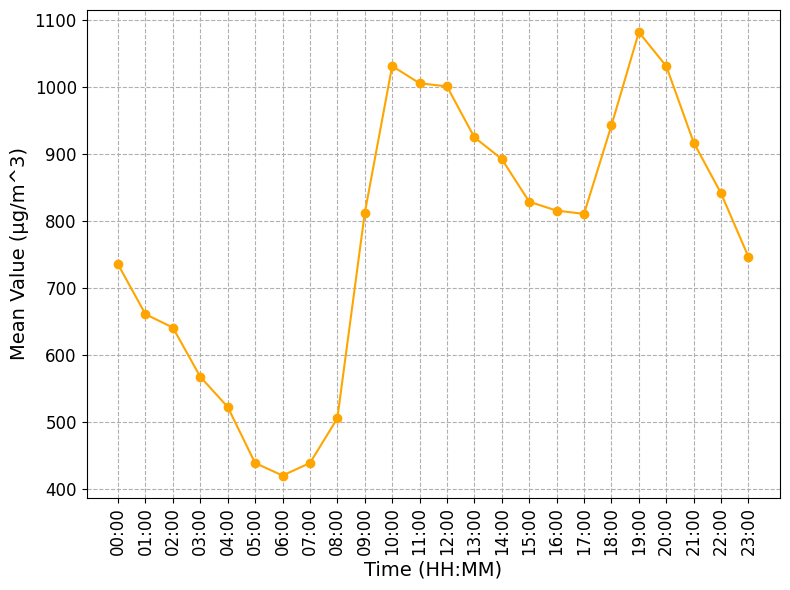

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/co_value.xlsx'
fd = pd.read_excel(file_path)

fd['date'] = pd.to_datetime(fd['date'])

filtered_data = fd[(fd['stationId'] == 'k12') & (fd['date'].dt.strftime('%Y-%m') == '2023-01')]
filtered_data['time'] = pd.to_datetime(filtered_data['time'], format='%H:%M:%S').dt.strftime('%H:%M')

mean_values_by_time = filtered_data.groupby(filtered_data['time'])['value'].mean().reset_index()

mean_values_by_time = mean_values_by_time.sort_values('time')

plt.figure(figsize=(8, 6))
plt.plot(mean_values_by_time['time'], mean_values_by_time['value'], color='orange', marker='o')

plt.xlabel('Time (HH:MM)', fontsize=14)
plt.ylabel('Mean Value (μg/m^3)', fontsize=14)

plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='dashed')

plt.tight_layout()

plt.show()

<ipython-input-17-3b8f1c37e3f6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'], format='%H:%M:%S').dt.strftime('%H:%M')


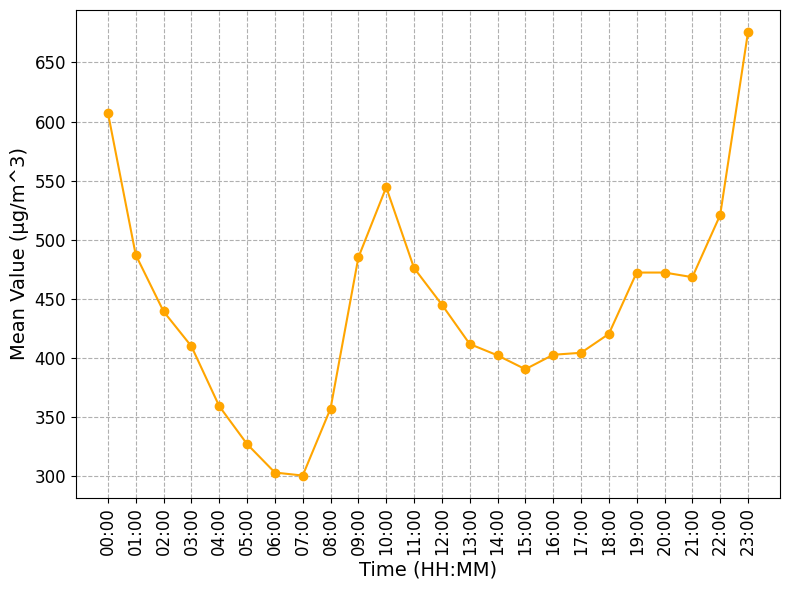

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/co_value.xlsx'
fd = pd.read_excel(file_path)

filtered_data = fd[(fd['stationId'] == 'k12') & (fd['date'].dt.strftime('%Y-%m') == '2023-07')]
filtered_data['time'] = pd.to_datetime(filtered_data['time'], format='%H:%M:%S').dt.strftime('%H:%M')

mean_values_by_time = filtered_data.groupby(filtered_data['time'])['value'].mean().reset_index()

mean_values_by_time = mean_values_by_time.sort_values('time')

plt.figure(figsize=(8, 6))
plt.plot(mean_values_by_time['time'], mean_values_by_time['value'], color='orange', marker='o')

plt.xlabel('Time (HH:MM)', fontsize=14)
plt.ylabel('Mean Value (μg/m^3)', fontsize=14)

plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='dashed')

plt.tight_layout()

plt.show()

In [8]:
import folium
import pandas as pd

data = pd.read_excel('/content/astana_station.xlsx')

m = folium.Map(location=[data['lat'].mean(), data['lng'].mean()], zoom_start=10)

for _, row in data.iterrows():
    marker_color = 'red' if row['status'] != 'ok' else 'blue'

    popup_content = f"""
    <b>{row['stationId']}</b><br>
    <table>
        <tr><td>City:</td><td>{row['city']}</td></tr>
        <tr><td>Station:</td><td>{row['stationId']}</td></tr>
        <tr><td>Address:</td><td>{row['address']}</td></tr>
        <tr><td>Sea Level:</td><td>{row['sea_level']}</td></tr>
        <tr><td>Status:</td><td>{row['status']}</td></tr>
    </table>
    """

    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=folium.Popup(popup_content, max_width=300),
        tooltip=row['stationId'],
        icon=folium.Icon(color=marker_color)
    ).add_to(m)

m.save('/content/astana_station_map.html')